# Adding pruning 

How to select pruning pints:
- two points 
- convex between them 
- at random 
- at a fixed distance

In [1]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
import random
from matplotlib import colormaps

<IPython.core.display.Javascript object>


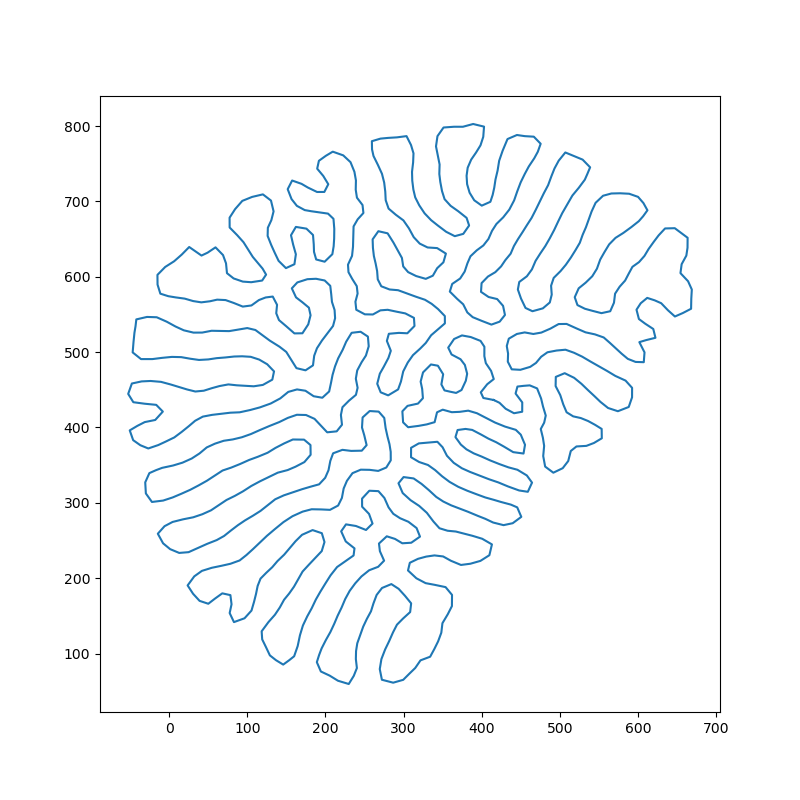

In [6]:
class particle(): 
    def __init__(self, x, y, index):
        self.position = np.array((x,y))
        self.velocity = np.array((0.0,0.0))
        self.index = index
    
    def update(self, clump, repulsion_distance, k, n, insert_distance,x_v,y_v):
        forces = np.zeros(2)     
        p2 = np.array((x_v,y_v)).T
        p2 = p2[np.all(p2!=self.position,1)]

        dist_v = np.sqrt(np.sum((p2 - self.position) ** 2,1))

        p2 = p2[dist_v<repulsion_distance]
        dist_v = dist_v[dist_v<repulsion_distance]
        diff = p2-self.position
        diff = normalize(diff[:], axis=1)
        diff = np.multiply(diff.T,-1/(dist_v**2))
        forces += diff.T.sum(0)
        
        # Neigbours
        # Left 
        neighbor = (n+1)%len(clump)
        p2 = clump[neighbor]
        diff = p2.position-self.position
        distance = mymagn(p2.position,self.position)
        diff = normalize(diff[:,np.newaxis], axis=0).ravel()
        diff = diff*1/(distance*distance)
        if distance < insert_distance*0.5:
            diff*=-1
        forces += diff
        
        # Right
        neighbor = ((n-1)+len(clump))%len(clump)
        p2 = clump[neighbor]
        diff = p2.position-self.position
        distance = mymagn(p2.position,self.position)
        diff = normalize(diff[:,np.newaxis], axis=0).ravel()
        diff = diff*1/(distance*distance)
        if distance < insert_distance*0.5:
            diff*=-1
        forces += diff
        
        acceleration = forces * k /1  # no mass change, mass is always 1
        self.velocity += acceleration 

    def update_position(self):
        self.position += self.velocity
        self.velocity *= 0.7
        
#     def update(self):
        
# Adding a particle 
def mymagn(A, B):
    return np.sqrt(np.sum((B - A) ** 2))

def adding_particle(clump, cutoff):
    number_of_particles = len(clump)
    i = 0
    while i < number_of_particles:
        p1 = clump[i]
        p2 = clump[(i+1)%number_of_particles]
        mag = mymagn(p2.position,p1.position)
        if mag>cutoff: 
            diff = p1.position+(p2.position-p1.position)*0.5
            new_p = particle(diff[0],diff[1], len(clump))
            clump.insert((i+1)%number_of_particles, new_p)
            i+=1
        i+=1
        number_of_particles = len(clump)
        
def prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 60,
         prob_cut = 0.3, concave_cut = False):
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]

    positions = np.array((x_v,y_v)).T
    dist_v = np.sqrt(np.sum((positions - np.array((400,500))) ** 2,1))
    index_array = np.arange(len(positions))

    mask = (dist_v>min_circle) & (dist_v<max_circle)
    possible_points = positions[mask]


    possible_points_index = index_array[mask]

    indices_to_cut = []

    for i in range(len(possible_points)):
        i_2 = (i+1)%len(possible_points)
        p1 = possible_points[i]
        p2 =  possible_points[i_2]

        # Distance not too long/not too short 
        dist_p1_p2 = np.sqrt(np.sum((p2 - p1) ** 2))
        
        #print(dist_p1_p2)
        if (dist_p1_p2>min_dist_cut) & (dist_p1_p2<max_dist_cut):

            # Convexity (take care when there is point 0 in between)
            p1_index = possible_points_index[i]
            p2_index =  possible_points_index[i_2]

            if p2_index>p1_index:
                interesting_index = np.arange(p1_index+1,p2_index)
            else:
                interesting_index = np.concatenate((np.arange(p1_index+1,len(positions)), np.arange(0,p2_index)))

            dist_check = dist_v[interesting_index]

            if all(dist_check> min_circle):
                if random.random()<=prob_cut:
                    indices_to_cut += list(interesting_index)
            if concave_cut:
                if all(dist_check < min_circle):
                    if random.random()<=prob_cut:
                        indices_to_cut += list(interesting_index)

    for index in sorted(indices_to_cut, reverse=True):
        del clump[index]
    return clump

def myPlot(clump, scatter=False):
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    if len(ax.lines)==0:
        ax.plot(x,y)
        if scatter: 
            ax.scatter(x,y)
    else:
        ax.lines[0].set_xdata(x)
        ax.lines[0].set_ydata(y)
        
    # recompute the ax.dataLim
    ax.relim()
    # update ax.viewLim using the new dataLim
    ax.autoscale_view()
        
    fig.canvas.draw()
    plt.pause(0.0001)



clump = []
number_of_particles = 5
radius = 40
width = 800
height =1000
insert_distance = 15
repulsion_distance = insert_distance * 5
k = 20
number_of_steps=100

# Initialiazation 
for i in range(number_of_particles):
    angle = i/number_of_particles*2*np.pi
    radius = 40 + random.uniform(-1, 1)#np.random.randint(-1,1)
    x = 0.5*width+radius*np.cos(angle)
    y = 0.5*height+radius*np.sin(angle)
    new_particle = particle(x,y,i)
    clump.append(new_particle)
    

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.show()



In [7]:
myPlot(clump)
number_of_steps=1000
res ={}

for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    # FORCES 
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance,x_v,y_v)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    res[i] = {"x":x,"y":y,"z":z}
    # PLOT 
    if i%10==0:
        myPlot(clump)
    
    if i>=0:
        # CUT 
        prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 40,
             prob_cut = 0.01, concave_cut=False)
    
    # ADD 
    adding_particle(clump, insert_distance)

<IPython.core.display.Javascript object>


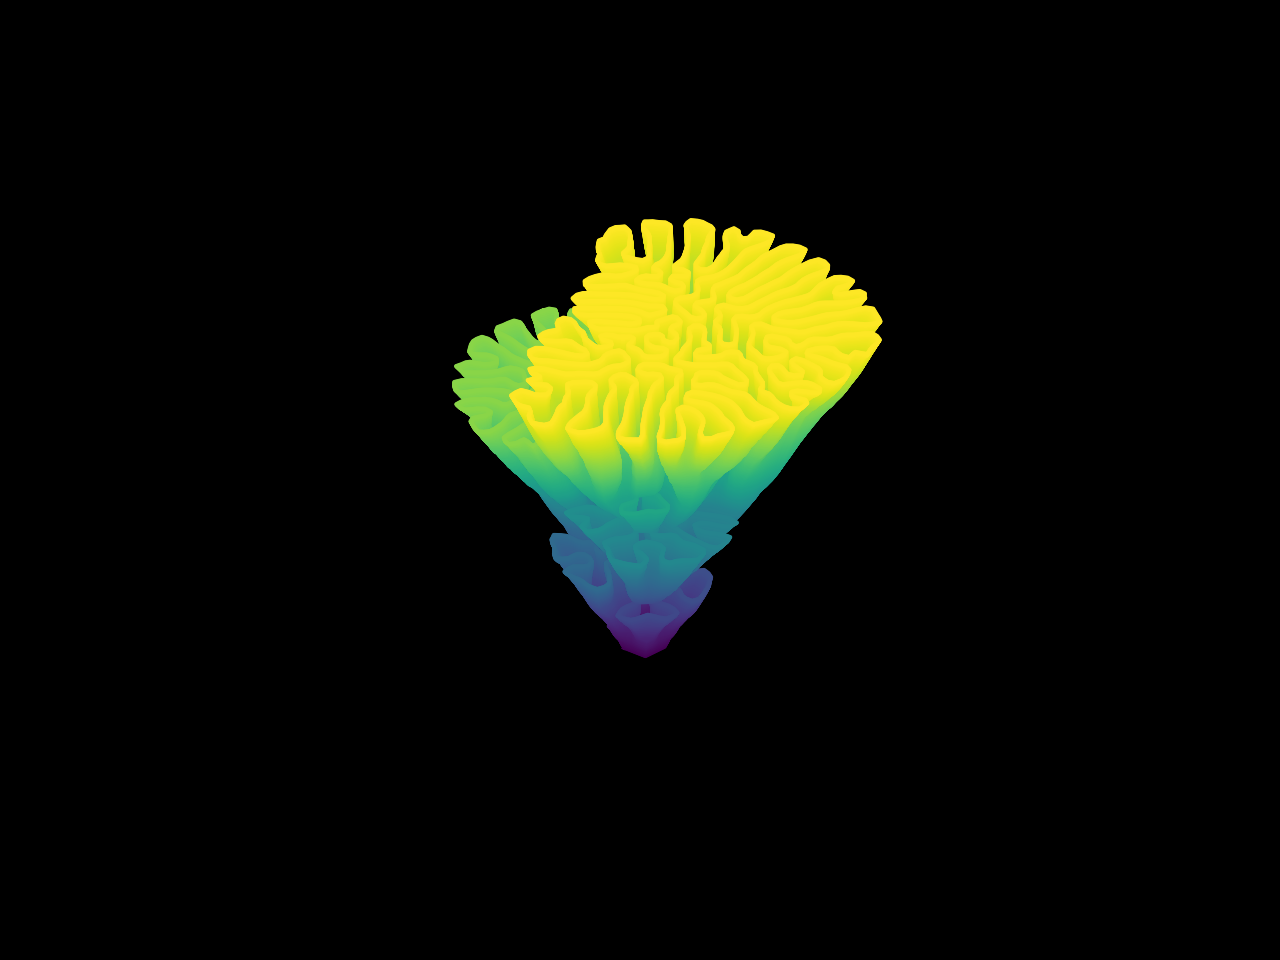

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')

for i in res: 
    ax.plot(res[i]["x"],res[i]["y"],res[i]["z"], c = cmap(res[i]["z"][0]/len(res)))
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

In [12]:
# import pickle

# with open('favorite.pkl', 'wb') as f:
#     pickle.dump(clump, f)

In [13]:
# with open('favorite.pkl', 'rb') as f:
#     x = pickle.load(f)

<IPython.core.display.Javascript object>


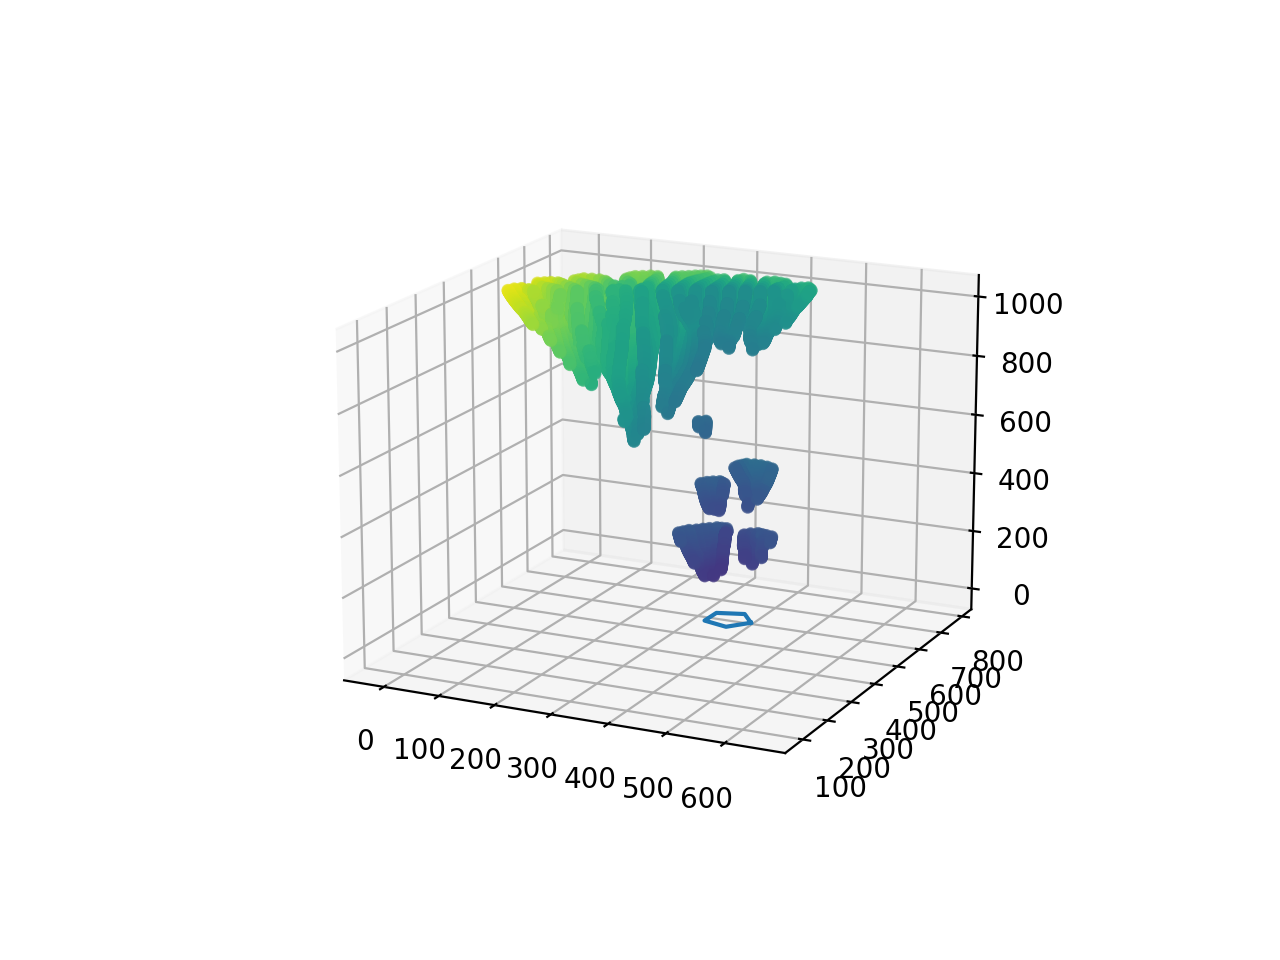

In [320]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')
tot_x = []
tot_y = []
tot_z = []
for i in res: 
    tot_x += res[i]["x"]
    tot_y += res[i]["y"]
    tot_z += res[i]["z"]
p2 = np.array((tot_x,tot_y)).T
ax.scatter(tot_x, tot_y, tot_z, c = np.sqrt(np.sum((p2 - np.array((400,500))) ** 2,1)), cmap=plt.cm.viridis, linewidth=0.2)

<IPython.core.display.Javascript object>


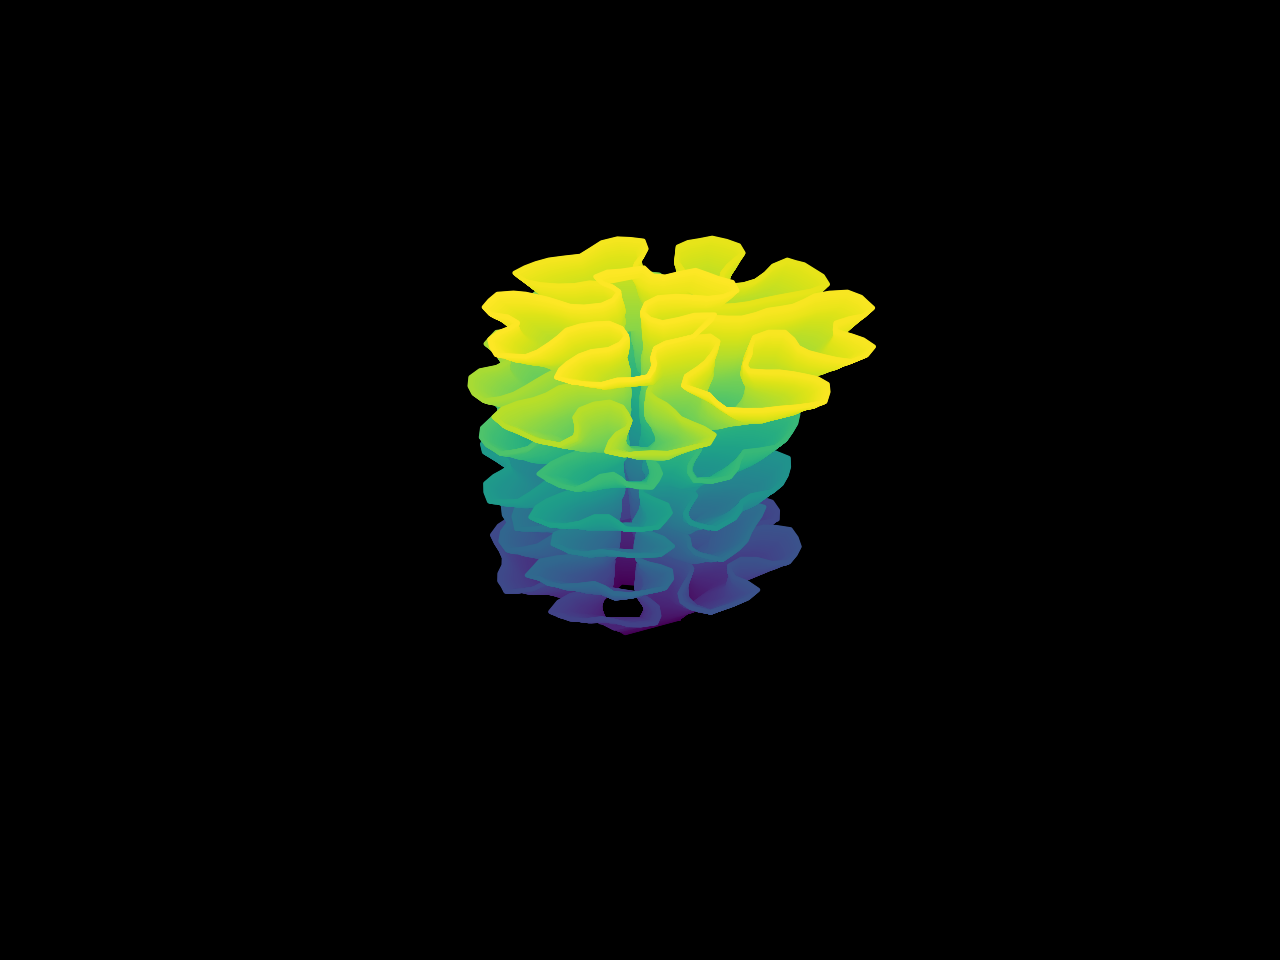

In [325]:
# NICE VERSION
clump = []
number_of_particles = 5
radius = 40
width = 800
height =1000
insert_distance = 15
repulsion_distance = insert_distance * 5
k = 20
number_of_steps=100

# Initialiazation 
for i in range(number_of_particles):
    angle = i/number_of_particles*2*np.pi
    radius = 40 + random.uniform(-1, 1)#np.random.randint(-1,1)
    x = 0.5*width+radius*np.cos(angle)
    y = 0.5*height+radius*np.sin(angle)
    new_particle = particle(x,y,i)
    clump.append(new_particle)
    
# myPlot(clump)
number_of_steps=1000
res ={}

for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    # FORCES 
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance,x_v,y_v)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    res[i] = {"x":x,"y":y,"z":z}
    # PLOT 
#     if i%10==0:
#         print(i)
    
    # CUT 
    prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 40,
         prob_cut = 0.1)
    
    # ADD 
    adding_particle(clump, insert_distance)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')

for i in res: 
    ax.plot(res[i]["x"],res[i]["y"],res[i]["z"], c = cmap(res[i]["z"][0]/len(res)))
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

<IPython.core.display.Javascript object>


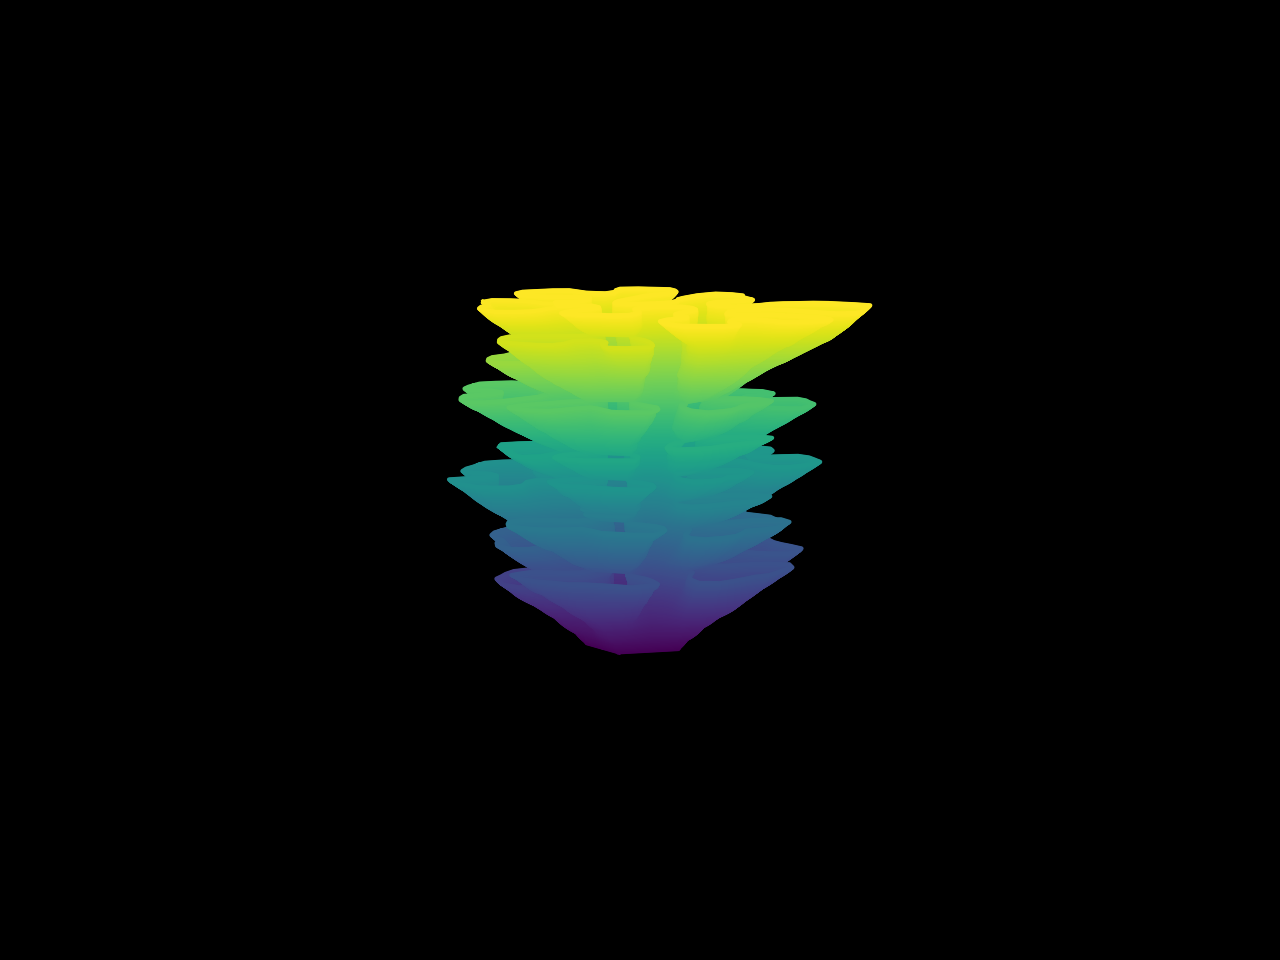

In [326]:
# OTHER INTERESTING SHAPE
clump = []
number_of_particles = 5
radius = 40
width = 800
height =1000
insert_distance = 15
repulsion_distance = insert_distance * 5
k = 20
number_of_steps=100

# Initialiazation 
for i in range(number_of_particles):
    angle = i/number_of_particles*2*np.pi
    radius = 40 + random.uniform(-1, 1)#np.random.randint(-1,1)
    x = 0.5*width+radius*np.cos(angle)
    y = 0.5*height+radius*np.sin(angle)
    new_particle = particle(x,y,i)
    clump.append(new_particle)
    
# myPlot(clump)
number_of_steps=1000
res ={}

for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    # FORCES 
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance,x_v,y_v)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    res[i] = {"x":x,"y":y,"z":z}
    # PLOT 
#     if i%10==0:
#         myPlot(clump)
    
    if i>=100:
        # CUT 
        prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 40,
             prob_cut = 0.05)
    
    # ADD 
    adding_particle(clump, insert_distance)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')

for i in res: 
    ax.plot(res[i]["x"],res[i]["y"],res[i]["z"], c = cmap(res[i]["z"][0]/len(res)))
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

<IPython.core.display.Javascript object>


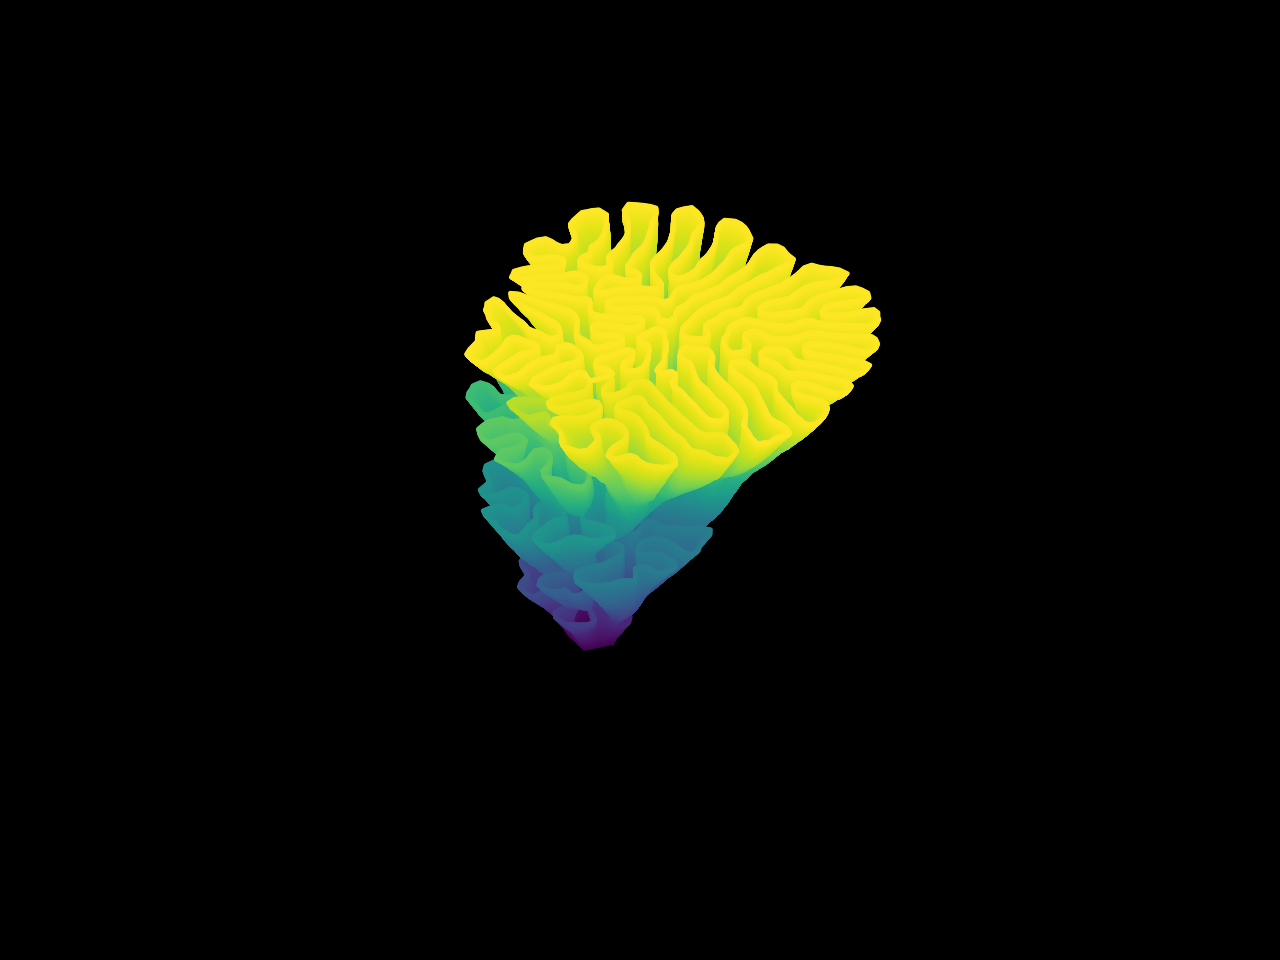

In [329]:
# OTHER INTERESTING SHAPE
clump = []
number_of_particles = 5
radius = 40
width = 800
height =1000
insert_distance = 15
repulsion_distance = insert_distance * 5
k = 20
number_of_steps=100

# Initialiazation 
for i in range(number_of_particles):
    angle = i/number_of_particles*2*np.pi
    radius = 40 + random.uniform(-1, 1)#np.random.randint(-1,1)
    x = 0.5*width+radius*np.cos(angle)
    y = 0.5*height+radius*np.sin(angle)
    new_particle = particle(x,y,i)
    clump.append(new_particle)
    
# myPlot(clump)
number_of_steps=1000
res ={}

for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    # FORCES 
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance,x_v,y_v)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    res[i] = {"x":x,"y":y,"z":z}
    # PLOT 
#     if i%10==0:
#         myPlot(clump)
    
    if i>=100:
        # CUT 
        prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 40,
             prob_cut = 0.01)
    
    # ADD 
    adding_particle(clump, insert_distance)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')

for i in res: 
    ax.plot(res[i]["x"],res[i]["y"],res[i]["z"], c = cmap(res[i]["z"][0]/len(res)))
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

<IPython.core.display.Javascript object>


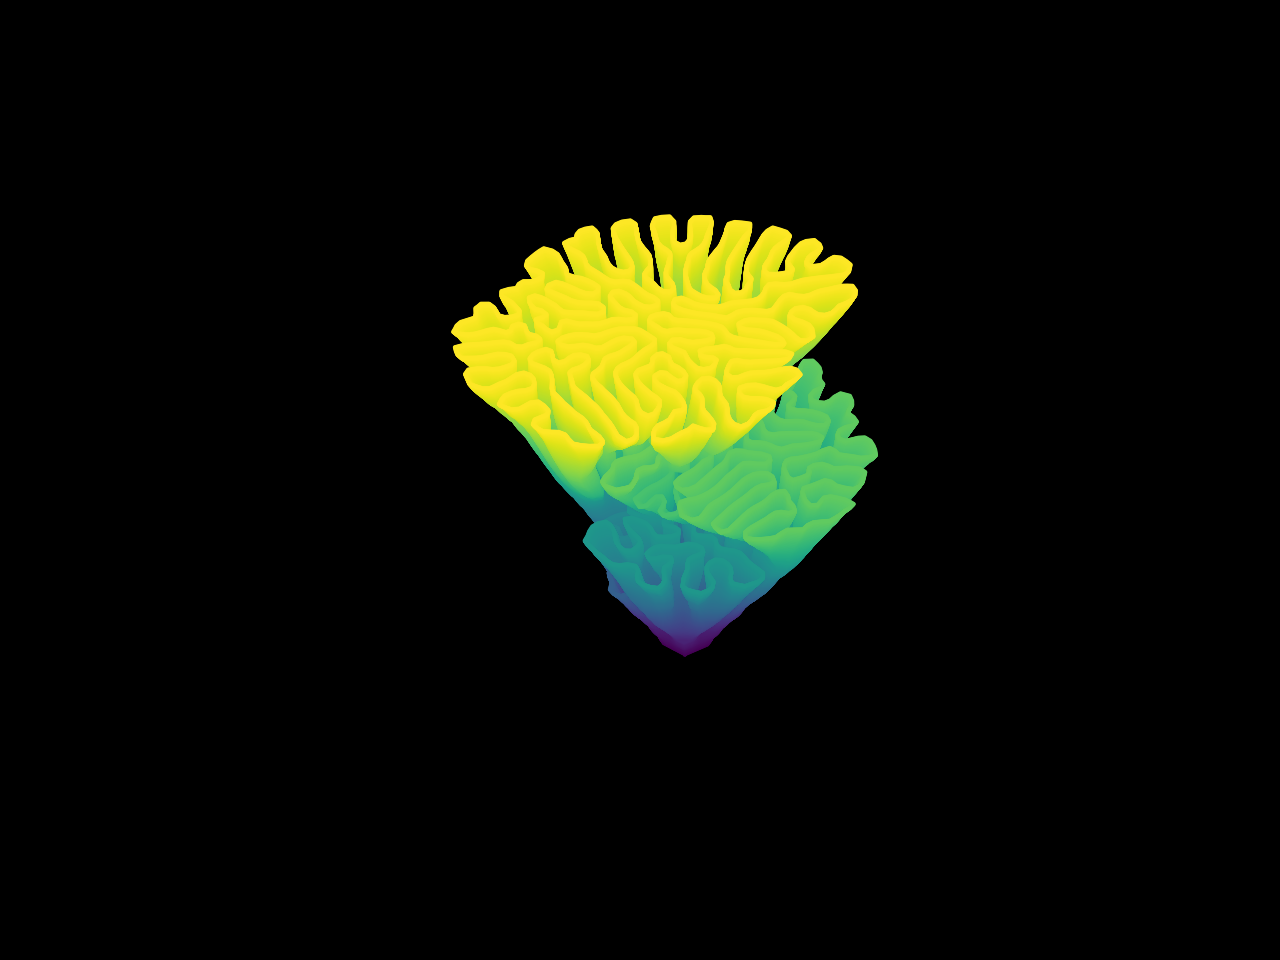

In [327]:
# ALSO NICE

clump = []
number_of_particles = 5
radius = 40
width = 800
height =1000
insert_distance = 15
repulsion_distance = insert_distance * 5
k = 20
number_of_steps=100

# Initialiazation 
for i in range(number_of_particles):
    angle = i/number_of_particles*2*np.pi
    radius = 40 + random.uniform(-1, 1)#np.random.randint(-1,1)
    x = 0.5*width+radius*np.cos(angle)
    y = 0.5*height+radius*np.sin(angle)
    new_particle = particle(x,y,i)
    clump.append(new_particle)

# myPlot(clump)
number_of_steps=1000
res ={}

for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    # FORCES 
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance,x_v,y_v)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    res[i] = {"x":x,"y":y,"z":z}
#     # PLOT 
#     if i%10==0:
#         myPlot(clump)
    
    if i>=0:
        # CUT 
        prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 40,
             prob_cut = 0.01)
    
    # ADD 
    adding_particle(clump, insert_distance)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')

for i in res: 
    ax.plot(res[i]["x"],res[i]["y"],res[i]["z"], c = cmap(res[i]["z"][0]/len(res)))
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

<IPython.core.display.Javascript object>


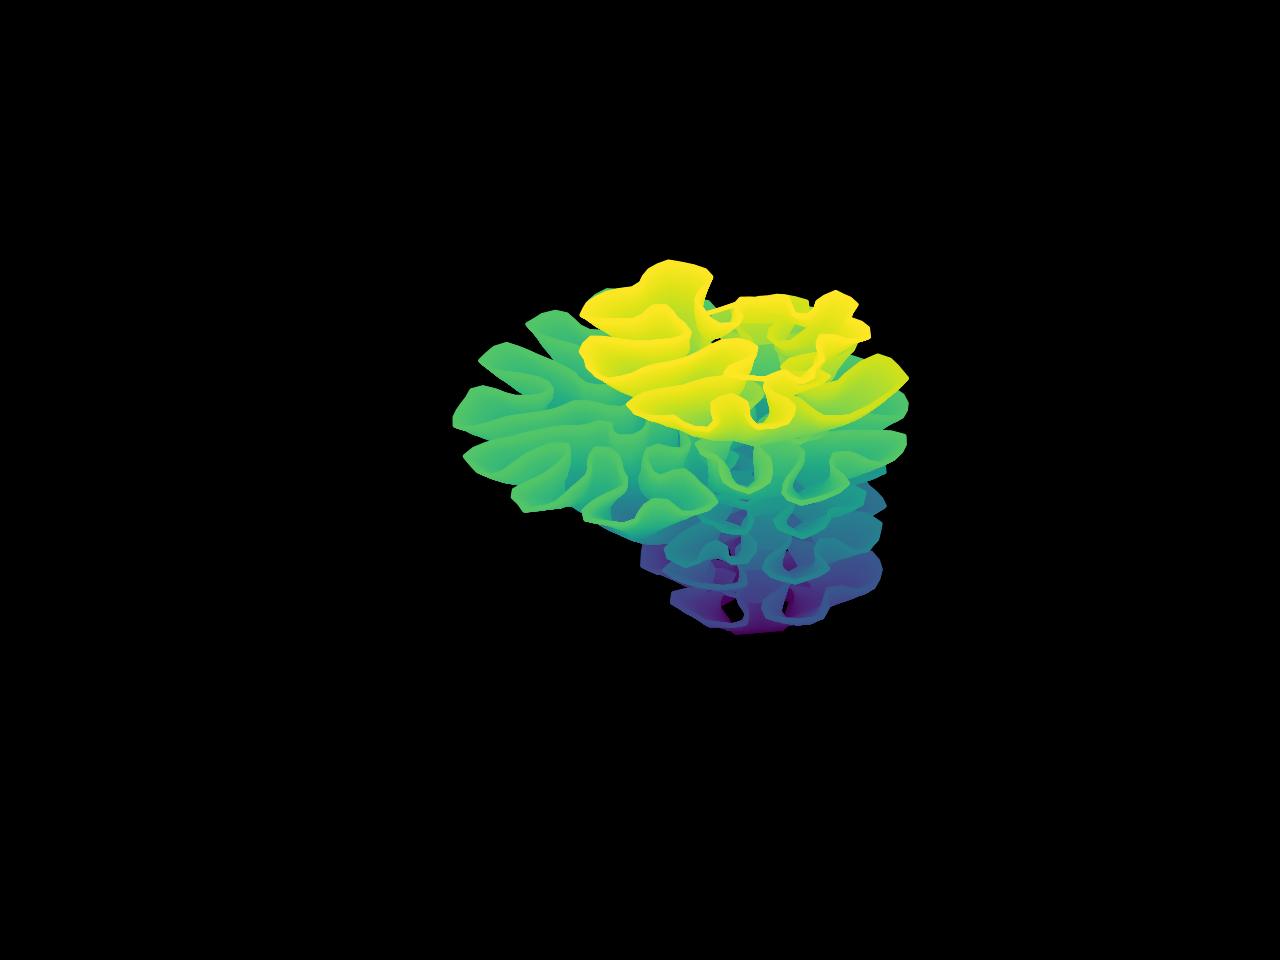

In [328]:
# ALSO INTERESTING
clump = []
number_of_particles = 5
radius = 40
width = 800
height =1000
insert_distance = 15
repulsion_distance = insert_distance * 5
k = 20
number_of_steps=100

# Initialiazation 
for i in range(number_of_particles):
    angle = i/number_of_particles*2*np.pi
    radius = 40 + random.uniform(-1, 1)#np.random.randint(-1,1)
    x = 0.5*width+radius*np.cos(angle)
    y = 0.5*height+radius*np.sin(angle)
    new_particle = particle(x,y,i)
    clump.append(new_particle)
    
# myPlot(clump)
number_of_steps=1000
res ={}

for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    # FORCES 
    x_v = [p.position[0] for p in clump]
    y_v = [p.position[1] for p in clump]
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance,x_v,y_v)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    res[i] = {"x":x,"y":y,"z":z}
    # PLOT 
#     if i%10==0:
#         myPlot(clump)
    
    if i>=0:
        # CUT 
        prune(clump, min_circle = 60, max_circle = 70, min_dist_cut = 0, max_dist_cut = 40,
             prob_cut = 0.04, concave_cut=True)
    
    # ADD 
    adding_particle(clump, insert_distance)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = colormaps.get_cmap('viridis')

for i in res: 
    ax.plot(res[i]["x"],res[i]["y"],res[i]["z"], c = cmap(res[i]["z"][0]/len(res)))
fig.set_facecolor('black')
ax.set_facecolor('black')
ax.grid(False)
ax.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))

In [238]:
myPlot(clump)
number_of_steps=100
tot_x = []
tot_y = []
tot_z = []
for i in range(number_of_steps): 
    number_of_particles = len(clump)
    n = 0
    while n < number_of_particles:
        p = clump[n]
        p.update(clump, repulsion_distance, k, n, insert_distance)
        n +=1
    for p in clump: 
        p.update_position()
    
    # saving position for 3d plot
    x = [p.position[0] for p in clump]
    y = [p.position[1] for p in clump]
    x.append(x[0])
    y.append(y[0])
    z = [i for t in x]
    tot_x += x
    tot_y += y
    tot_z += z
    
    adding_particle(clump, insert_distance)
    if i%10==0:
        myPlot(clump)

TypeError: particle.update() missing 2 required positional arguments: 'x_v' and 'y_v'

<IPython.core.display.Javascript object>


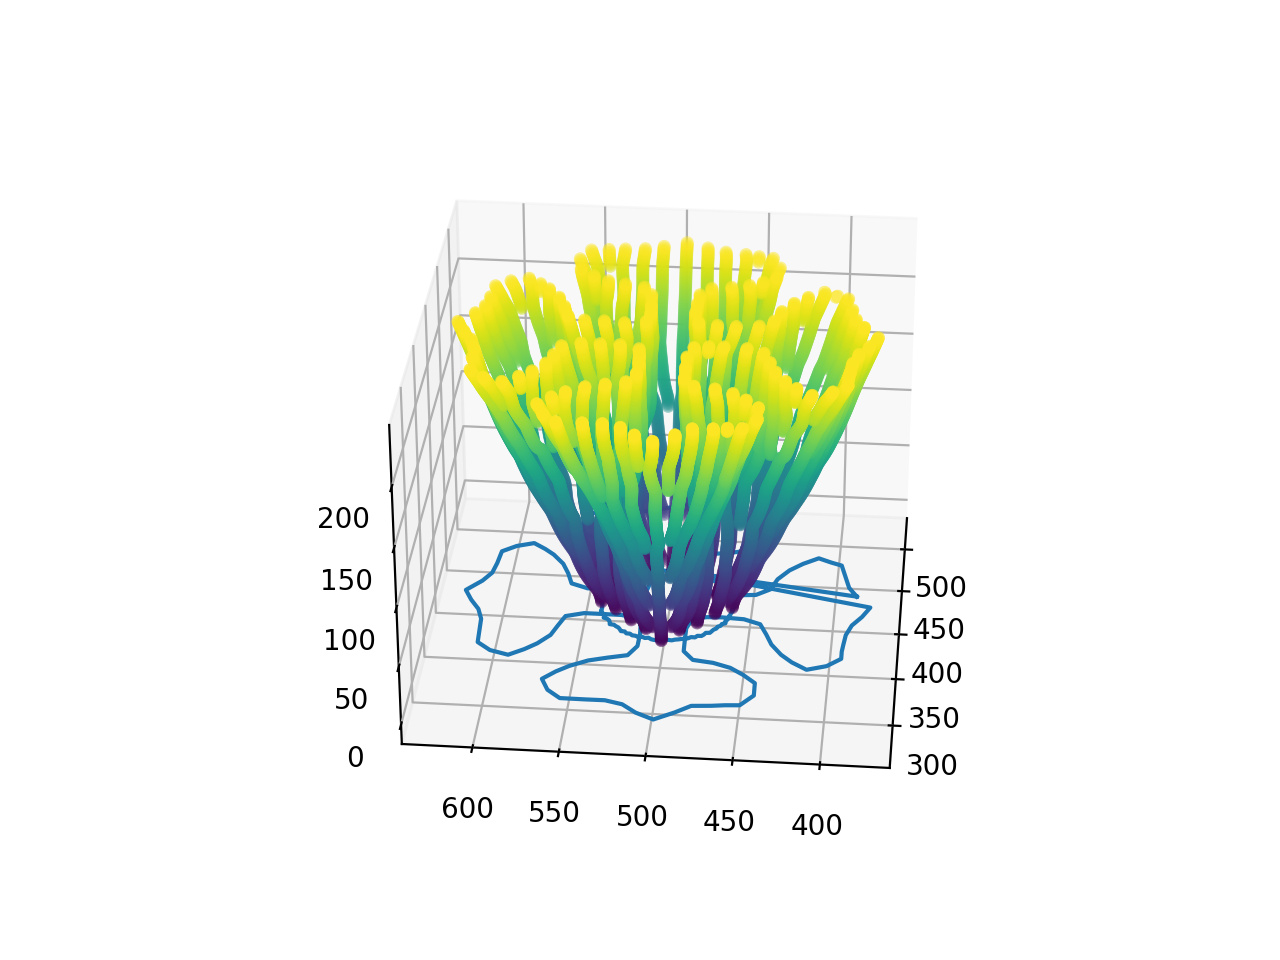

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tot_x, tot_y, tot_z, c = tot_z, cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, 185)
plt.show()
